In [1]:
import pandas as pd
import os
import librosa
import numpy as np
import torch 
import matplotlib.pyplot as plt
import librosa.display
from torch.nn.functional import one_hot

In [ ]:
# 1. Definir o caminho raiz onde estão as pastas fold1 a fold10
CAMINHO_RAIZ_AUDIO = r"C:\Users\jproc_vj4ovlo\Desktop\TrabalhoAC\UrbanSound8K\UrbanSound8K\audio"

# 2. Definir o caminho para o ficheiro CSV (assumindo que está na pasta principal do dataset)
CAMINHO_CSV = r"C:\Users\jproc_vj4ovlo\Desktop\TrabalhoAC\UrbanSound8K\UrbanSound8K\metadata\UrbanSound8K.csv"

# 3. Carregar o ficheiro CSV
metadata = pd.read_csv(CAMINHO_CSV)


# 1 Pré Processamento dos Dados

In [3]:
TARGET_SR = 22050  # Taxa de amostragem alvo 
DURACAO_ALVO_SEGUNDOS = 4.0  # Duração do Audio
NUM_AMPLITUDES_ALVO = int(TARGET_SR * DURACAO_ALVO_SEGUNDOS) # 88200 Amplitudes por ficheiro de som 
N_MFCC = 40        # Número de coeficientes MFCC a extrair

Esta função recebe o caminho de um ficheiro de áudio e uma taxa de amostragem alvo (sendo escolhido 22050 Hz) e utiliza a biblioteca librosa para carregar o ficheiro, convertendo-o automaticamente para a taxa de amostragem especificada e para formato mono (canal único). A função retorna o sinal de áudio processado como um array NumPy.

In [4]:
#Uniformizar a Taxa de Amostragem
def uniformizar_sampling_rate(caminho_ficheiro, taxa_alvo=TARGET_SR):
    try:
        # Carrega e reamostra numa única operação
        sinal_audio, sr = librosa.load(
            caminho_ficheiro, 
            sr=taxa_alvo, 
            mono=True
        )
        return sinal_audio
    except Exception as e:
        print(f"Erro ao processar o ficheiro {caminho_ficheiro}: {e}")
        return None

Esta função garante que todos os sinais de áudio tenham exatamente o mesmo número de amostras (NUM_AMPLITUDES_ALVO). A função primeiro verifica se o sinal é válido e depois compara o comprimento atual do sinal com o comprimento alvo: 
- se o sinal for mais longo, é truncado mantendo apenas a parte inicial
- se for mais curto, são adicionados zeros no final para completar o tamanho necessário 
- se já tiver o tamanho correto, é retornado sem alterações
Esta normalização permite que ficheiros de áudio com durações diferentes sejam processados de forma uniforme, criando um dataset homogéneo onde todos os exemplos têm as mesmas dimensões.

In [5]:
#Normalização da Duração e Padding
def normalizar_duracao(sinal_audio, num_amostras_alvo = NUM_AMPLITUDES_ALVO):
    
    # Trunca ou aplica padding a um sinal de áudio para que tenha um número fixo de amostras.
    
    
    if sinal_audio is None:
        return None
        
    num_amostras_atuais = len(sinal_audio)
    
    if num_amostras_atuais > num_amostras_alvo:
        # Truncagem (mantendo o início)
        sinal_normalizado = sinal_audio[:num_amostras_alvo]
        
    elif num_amostras_atuais < num_amostras_alvo:
        # Padding (adicionar zeros no final)
        padding_necessario = num_amostras_alvo - num_amostras_atuais
        
        sinal_normalizado = np.pad(
            sinal_audio, 
            (0, padding_necessario), 
            mode='constant'
        )
        
    else:
        # Já tem o tamanho alvo
        sinal_normalizado = sinal_audio
        
    return sinal_normalizado

Esta função  é responsável por transformar o sinal de áudio normalizado numa representação de características espectrais chamada MFCCs (Mel-Frequency Cepstral Coefficients). A função recebe o sinal de áudio já processado, a taxa de amostragem e o número de coeficientes MFCCs a extrair. Utilizando a biblioteca librosa, a função aplica o método `librosa.feature.mfcc()` que extrai os coeficientes MFCCs do sinal de áudio, retornando uma matriz bidimensional onde cada coluna representa um frame temporal e cada linha representa um coeficiente MFCC específico.

Os MFCCs são uma das representações de características mais populares em tarefas de processamento de áudio e reconhecimento de sons porque capturam as propriedades espectrais do áudio de forma compacta e eficiente, imitando a forma como o ouvido humano percebe o som. O processo de extração envolve várias etapas:
1. Aplica-se a transformada de Fourier para converter o sinal do domínio temporal para o domínio da frequência
2. Aplica-se uma escala mel que mapeia as frequências para uma escala perceptual que reflete melhor como os humanos distinguem diferentes frequências (sendo mais sensíveis a frequências baixas)
3. Aplica-se a transformada discreta do cosseno (DCT) para decorrelacionar os coeficientes e obter uma representação compacta. 
Os primeiros coeficientes MFCCs capturam a forma geral do espectro (o "envelope" espectral), enquanto os coeficientes superiores capturam detalhes mais finos da textura sonora.

A escolha de 40 coeficientes MFCCs representa um equilíbrio entre capturar informação suficiente sobre as características do áudio e manter uma representação compacta que não seja excessivamente redundante ou computacionalmente pesada.

 Embora valores típicos variem entre 13 e 20 coeficientes para tarefas de reconhecimento de fala, utilizar 40 coeficientes pode ser vantajoso para classificação de sons ambientais (como no dataset UrbanSound8K) porque estes sons tendem a ter estruturas espectrais mais complexas e variadas do que a fala humana, beneficiando de uma representação mais detalhada. Os coeficientes adicionais permitem capturar nuances subtis que distinguem diferentes tipos de sons urbanos (como buzinas de carros, sirenes, latidos de cães ou obras de construção), melhorando potencialmente a precisão do modelo.

In [6]:
def extrair_mfccs (sinal_normalizado, sr=TARGET_SR, n_mfcc=N_MFCC):
    # Extrai os MFCCs 
    if sinal_normalizado is None:
        return None
        
    # Extração dos MFCCs
    mfccs = librosa.feature.mfcc(
        y=sinal_normalizado, 
        sr=sr, 
        n_mfcc=n_mfcc
    )
    
    # Opcional: Transpor a matriz para (num_frames, n_mfcc) se preferir esta ordem
    # mfccs = mfccs.T 
    
    return mfccs

O processo começa por carregar os metadados do ficheiro CSV e depois itera sobre cada entrada, construindo o caminho completo de cada ficheiro de áudio através da combinação da pasta fold com o nome do ficheiro. Para cada ficheiro, são aplicadas duas transformações sequenciais: 
1. Uniformização da taxa de amostragem  
2. Normalização da duração 
3. Extração dascaracterísticas MFCCs (Mel-Frequency Cepstral Coefficients)
Garantindo que todos os sinais têm a mesma taxa de amostragem e o mesmo comprimento. 

Todos os ficheiros processados com sucesso são armazenados na lista `dados_processados`, cada um como um dicionário contendo os MFCCs extraídos, a classe do som, o número da fold e o nome do ficheiro.

In [7]:
def processar_dataset(caminho_csv, caminho_raiz_audio):
    metadata = pd.read_csv(CAMINHO_CSV)
    dados_processados = []

    for index, row in metadata.iterrows():
        fold_name = f"fold{row['fold']}"
        file_name = row['slice_file_name']
        caminho_completo = os.path.join(CAMINHO_RAIZ_AUDIO, fold_name, file_name)
        
        #Uniformizar Taxa de Amostragem
        sinal_reamostrado = uniformizar_sampling_rate(caminho_completo)
        
        if sinal_reamostrado is not None:
            # Normalização da Duração e Padding
            sinal_final = normalizar_duracao(sinal_reamostrado)
            

            # Extração de MFCCs

            mfccs_resultantes = extrair_mfccs(sinal_final)
            # Armazenar o resultado
            dados_processados.append({
                'mfccs': mfccs_resultantes,
                'classe': row['class'],
                'fold': row['fold'],
                'file_name': file_name
            })
            
            if index % 500 == 0:
                print(f"Processados {index} de {len(metadata)} ficheiros com mfccs pronto.")

    print("Processamento da  Normalização e Frquência concluidos.")

    return dados_processados


In [8]:
dataset_mfccs = processar_dataset(CAMINHO_CSV, CAMINHO_RAIZ_AUDIO)

Processados 0 de 8732 ficheiros com mfccs pronto.
Processados 500 de 8732 ficheiros com mfccs pronto.
Processados 1000 de 8732 ficheiros com mfccs pronto.
Processados 1500 de 8732 ficheiros com mfccs pronto.
Processados 2000 de 8732 ficheiros com mfccs pronto.
Processados 2500 de 8732 ficheiros com mfccs pronto.
Processados 3000 de 8732 ficheiros com mfccs pronto.
Processados 3500 de 8732 ficheiros com mfccs pronto.
Processados 4000 de 8732 ficheiros com mfccs pronto.
Processados 4500 de 8732 ficheiros com mfccs pronto.
Processados 5000 de 8732 ficheiros com mfccs pronto.
Processados 5500 de 8732 ficheiros com mfccs pronto.
Processados 6000 de 8732 ficheiros com mfccs pronto.
Processados 6500 de 8732 ficheiros com mfccs pronto.
Processados 7000 de 8732 ficheiros com mfccs pronto.
Processados 7500 de 8732 ficheiros com mfccs pronto.
Processados 8000 de 8732 ficheiros com mfccs pronto.
Processados 8500 de 8732 ficheiros com mfccs pronto.
Processamento da  Normalização e Frquência conclui

Esta função implementa a normalização Z-Score sobre o dataset de MFCCs, uma técnica crucial para garantir que os dados tenham média zero e desvio padrão unitário, o que ajuda a melhorar o desempenho e a estabilidade do treino de modelos.

O processo começa por agregar todos os arrays de MFCCs de todas as amostras do dataset numa única lista, depois concatena todos estes arrays num único vetor unidimensional para calcular as estatísticas globais (média e desvio padrão) que representam todo o conjunto de dados. Com estas estatísticas globais calculadas, a função percorre novamente cada item do dataset e aplica a transformação Z-Score `(mfccs - média) / desvio_padrão` a cada matriz de MFCCs, garantindo que todos os coeficientes sejam normalizados usando exatamente as mesmas estatísticas, independentemente da fold ou amostra a que pertencem.

- Esta abordagem de normalização global é preferível em tarefas de classificação de áudio porque garante consistência entre todas as amostras e evita o vazamento de informação que poderia ocorrer se normalizássemos cada amostra individualmente, preservando as relações relativas entre diferentes sons enquanto coloca todos os valores numa escala comparável.

In [9]:

# Função de Normalização 

def normalizar_mfccs_global_completo(dataset_mfccs):
    """
    Calcula a média e o desvio padrão sobre o dataset  e 
    aplica a normalização Z-Score a todos os elementos.
    
    Args:
        dataset_mfccs (list): Lista de dicionários com os MFCCs e metadados.

    Returns:
        list: O dataset com os MFCCs normalizados.
    """
    
    # 1. Agregação dos MFCCs do Dataset
    # mfccs_all contém todos os arrays 2D de MFCCs
    mfccs_all = [item['mfccs'] for item in dataset_mfccs]
    
    # 2. Cálculo das Estatísticas sobre o Dataset
    # np.concatenate(..., axis=None) achata todos os arrays 2D num único array 1D
    mfccs_all_concatenados = np.concatenate(mfccs_all, axis=None)
    
    media_global = np.mean(mfccs_all_concatenados)
    desvio_padrao_global = np.std(mfccs_all_concatenados)
    
    if desvio_padrao_global == 0:
        desvio_padrao_global = 1e-6 
        
    print(f"Estatísticas de Normalização (Global): Média={media_global:.4f}, DP={desvio_padrao_global:.4f}")

    # 3. Aplicação da Normalização 
    dataset_normalizado = []
    for item in dataset_mfccs:
        # Aplica a mesma estatística a todos os MFCCs
        mfccs_normalizados = (item['mfccs'] - media_global) / desvio_padrao_global
        
        novo_item = item.copy()
        novo_item['mfccs'] = mfccs_normalizados
        dataset_normalizado.append(novo_item)
        
    return dataset_normalizado


In [10]:
dataset_normalizado = normalizar_mfccs_global_completo(dataset_mfccs)

print(f"Normalização concluída. O primeiro MFCC normalizado tem shape: {dataset_normalizado[0]['mfccs'].shape}")

Estatísticas de Normalização (Global): Média=-4.5962, DP=55.6839
Normalização concluída. O primeiro MFCC normalizado tem shape: (40, 173)


Esta função transforma os rótulos numéricos das classes (classID) em vetores one-hot encoding utilizando PyTorch, uma representação essencial para treinar redes neuronais em tarefas de classificação multiclasse.

 O processo extrai todos os classIDs do dataset, converte-os num tensor PyTorch e aplica a função `torch.nn.functional.one_hot()` que cria vetores binários onde apenas a posição correspondente à classe tem valor 1 e todas as outras têm valor 0
 - por exemplo, a classe é  representada como `[0,0,0,1,0,0,0,0,0,0]`.
 
  A função então atualiza cada item do dataset adicionando um novo campo `label_one_hot` com o vetor codificado correspondente, mantendo os dados originais intactos.

In [11]:
# Mapeamento de Classes para IDs Numéricos (0 a 9)
CLASS_MAPPING = {
    'air_conditioner': 0,
    'car_horn': 1,
    'children_playing': 2,
    'dog_bark': 3,
    'drilling': 4,
    'engine_idling': 5,
    'gun_shot': 6,
    'jackhammer': 7,
    'siren': 8,
    'street_music': 9
}
NUM_CLASSES = len(CLASS_MAPPING)

In [12]:
# Função de Codificação dos Rótulos 

def codificar_rotulos_por_nome(dataset_normalizado):
    """
    Converte os rótulos de nome (ex: 'dog_bark') para One-Hot Encoding usando PyTorch,
    com base no mapeamento CLASS_MAPPING.
    
    Args:
        dataset_dataset_normalizadomfccs (list): Lista de dicionários (contém a chave 'classe' com o nome).

    Returns:
        list: O dataset com os rótulos codificados como tensores PyTorch.
    """
    
    # 1. Mapear nomes de classe para IDs numéricos
    rotulos_numericos = []
    for item in dataset_normalizado:
        class_name = item['classe'] 
        class_id = CLASS_MAPPING.get(class_name)
        
        if class_id is None:
            raise ValueError(f"Nome de classe '{class_name}' não encontrado no mapeamento.")
            
        rotulos_numericos.append(class_id)
        
    rotulos_numericos_np = np.array(rotulos_numericos, dtype=np.int64)
    
    # 2. Converter para Tensor PyTorch
    rotulos_tensor = torch.from_numpy(rotulos_numericos_np)
    
    # 3. Aplicar One-Hot Encoding
    rotulos_one_hot = one_hot(rotulos_tensor, num_classes=NUM_CLASSES).float()
    
    # 4. Atualizar o dataset com os rótulos codificados
    dataset_codificado = []
    for i, item in enumerate(dataset_normalizado):
        novo_item = item.copy()
        # Adicionar o novo rótulo codificado como Tensor PyTorch
        novo_item['label_one_hot'] = rotulos_one_hot[i]
        dataset_codificado.append(novo_item)
        
    return dataset_codificado


In [13]:
dataset_final = codificar_rotulos_por_nome(dataset_normalizado)

print(f"Codificação de rótulos concluída (PyTorch). Total de amostras: {len(dataset_final)}")
print(f"Rótulo One-Hot (Primeiro elemento): {dataset_final[0]['label_one_hot']}")
print(f"Tipo de dado: {dataset_final[0]['label_one_hot'].dtype}") # Deve ser torch.float32

Codificação de rótulos concluída (PyTorch). Total de amostras: 8732
Rótulo One-Hot (Primeiro elemento): tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
Tipo de dado: torch.float32


Visualização dos Dados

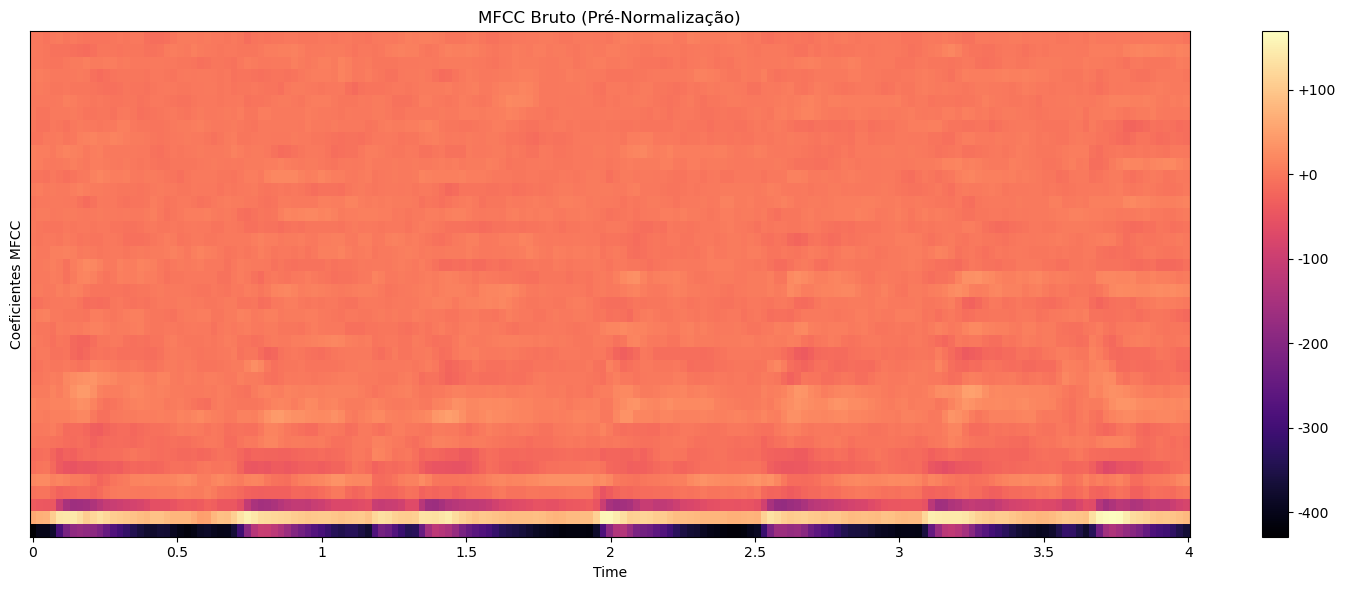

In [14]:
def visualizar_mfcc_bruto(mfcc_array, sr=22050, title="MFCC Bruto (Pré-Normalização)"):
    """
    Gera uma visualização da matriz MFCC antes da normalização Z-Score.
    A escala de cores é determinada automaticamente pelos valores brutos.

    Args:
        mfcc_array (np.array): A matriz 2D de MFCCs (resultado do Passo 1.4).
        sr (int): Taxa de amostragem.
        title (str): Título do gráfico.
    """
    
    # 1. Configurar a figura (Tamanho aumentado)
    plt.figure(figsize=(15, 6))
    
    # 2. Usar a função de visualização do librosa
    librosa.display.specshow(
        mfcc_array, 
        x_axis='time', 
        sr=sr, 
        # REMOVEMOS vmin e vmax para que a escala seja automática
        cmap='magma' # Um mapa de cores diferente para dados brutos pode ser útil
    )
    
    # 3. Adicionar elementos do gráfico
    # O formato da barra de cores agora mostra os valores brutos (ex: -400 a 100)
    plt.colorbar(format='%+2.f') 
    plt.title(title)
    
    # Adicionar rótulos no eixo Y
    plt.ylabel('Coeficientes MFCC')
    
    plt.tight_layout()
    plt.show()

# --- Execução do Código (Assumindo que 'dataset_mfccs' existe) ---

mfcc_exemplo = dataset_mfccs[17]['mfccs'] 
visualizar_mfcc_bruto(mfcc_exemplo)

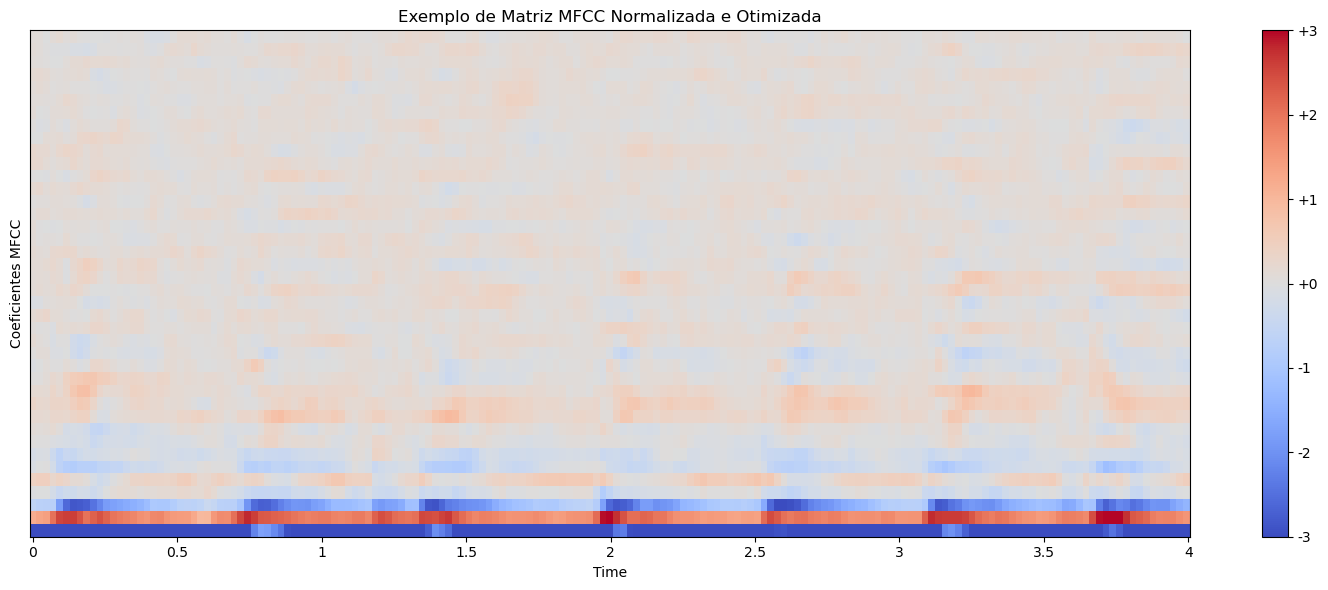

Fold: 2
Nome do Ficheiro: 100652-3-0-3.wav


In [15]:

def visualizar_mfcc(mfcc_array, sr=22050, title="MFCC Visualização Detalhada"):
    """
    Gera uma visualização da matriz MFCC como um espectrograma, 
    otimizada para dados normalizados.

    Args:
        mfcc_array (np.array): A matriz 2D de MFCCs normalizados (resultado do Passo 1.5).
        sr (int): Taxa de amostragem (para exibição do eixo do tempo).
        title (str): Título do gráfico.
    """
    
    # 1. Configurar a figura (Tamanho aumentado para melhor visualização)
    plt.figure(figsize=(15, 6))
    
    # 2. Usar a função de visualização do librosa
    librosa.display.specshow(
        mfcc_array, 
        x_axis='time', 
        sr=sr, 
        # Focar a escala de cores no intervalo Z-Score (Normalização)
        vmin=-3.0, 
        vmax=3.0,
        cmap='coolwarm' # Mapa de cores de alto contraste
    )
    
    # 3. Adicionar elementos do gráfico
    plt.colorbar(format='%+2.0f') # Formato mais limpo para a barra de cores
    plt.title(title)
    
    # Adicionar rótulos no eixo Y para indicar os coeficientes
    plt.ylabel('Coeficientes MFCC')
    
    plt.tight_layout()
    plt.show()

# --- Execução do Código (Assumindo que 'dataset_final' existe) ---

# 1. Visualização
mfcc_exemplo = dataset_final[17]['mfccs'] 
visualizar_mfcc(mfcc_exemplo, title="Exemplo de Matriz MFCC Normalizada e Otimizada")

# 2. Acesso aos Metadados
# Aceder à chave 'fold' do primeiro dicionário na lista dataset_final
print(f"Fold: {dataset_final[17]['fold']}")

# Aceder à chave 'file_name' do primeiro dicionário na lista dataset_final
print(f"Nome do Ficheiro: {dataset_final[17]['file_name']}")